In [6]:

import numpy as np

def davies_harte_fbm(N: int, H: float, T: float = 1.0, seed: int | None = None):
    """
    Davies–Harte simulation of fractional Brownian motion B_H on [0,T]
    with N steps (N+1 points).

    Returns
    -------
    t : (N+1,) time grid
    B : (N+1,) fBm path with B[0]=0
    X : (N,)   fractional Gaussian noise with Var=1 (before (Δt)^H scaling)
    """
    if not (0 < H < 1):
        raise ValueError("H must be in (0,1).")
    if N < 2:
        raise ValueError("N must be >= 2.")

    rng = np.random.default_rng(seed)
    dt = T / N
    M = 2 * N

    def gamma(k):
        k = np.asarray(k, dtype=float)
        return 0.5 * (np.abs(k + 1.0)**(2*H) - 2.0 * np.abs(k)**(2*H) + np.abs(k - 1.0)**(2*H))

    # Circulant first row
    c = np.concatenate([gamma(np.arange(0, N+1)), gamma(np.arange(N-1, 0, -1))])

    # Eigenvalues of the circulant covariance
    lam = np.fft.fft(c).real
    lam[lam < 0] = 0.0  # clip tiny negatives

    # Complex Gaussian with conjugate symmetry
    Z = np.zeros(M, dtype=complex)
    Z[0] = rng.normal()
    Z[N] = rng.normal()
    for k in range(1, N):
        a = rng.normal()
        b = rng.normal()
        Z[k] = (a + 1j*b) / np.sqrt(2.0)
        Z[M-k] = (a - 1j*b) / np.sqrt(2.0)

    # IFFT and scaling: NumPy's ifft has 1/M factor, so multiply by sqrt(M)
    Y = np.fft.ifft(np.sqrt(lam) * Z)
    X = np.real(Y[:N]) * np.sqrt(M)

    # Scale increments by (Δt)^H then cumulate
    B = np.empty(N+1)
    B[0] = 0.0
    B[1:] = np.cumsum((dt**H) * X)

    t = np.linspace(0.0, T, N+1)
    return t, B, X


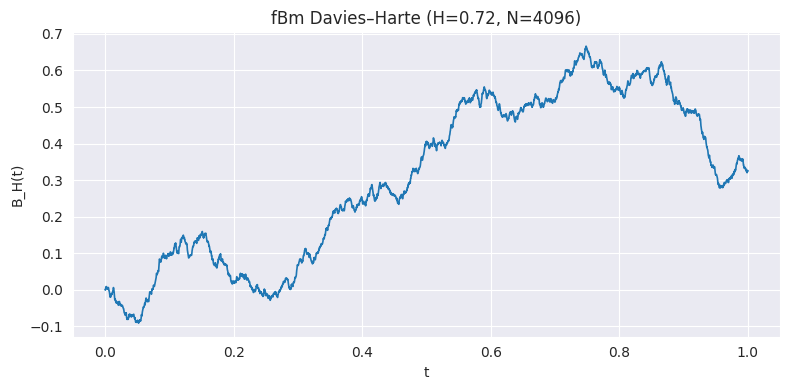

<Figure size 640x480 with 0 Axes>

In [7]:
import matplotlib.pyplot as plt


N, H, T = 4096, 0.72, 1.0
t, B, X = davies_harte_fbm(N, H, T, seed=7)

plt.figure(figsize=(8,4))
plt.plot(t, B, linewidth=1.2)
plt.title(f"fBm Davies–Harte (H={H}, N={N})")
plt.xlabel("t")
plt.ylabel("B_H(t)")
plt.tight_layout()
plt.show()               # affiche
plt.savefig("fbm_plot.png", dpi=160)  # optionnel: sauvegarde


